<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>


# 03 Extract the rind (compare to the other tissue extraction notebook)

Looking at individual fruit scans now, we can start segmenting the tissues of interest. 

- Exocarp
- Endocarp
- Rind
- Central column (spine)

Given the diversity of fruit shapes, and different scan qualities, I wasn't able to find a nice fully-automated solution.

- Instead, there I set a general process, a combination of basic image morphology operations in combination of some hyperparameters
- Manually set the hyperparameters for each fruit on a trial-and-error basis.

The order of the steps, _aka_ the order in which the tissues are extracted, had to be altered for some cases.
- Additional steps might also be required for other fruits

**Take this notebook as a _suggestion_ on how to extract tissues rather than an automated code**

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_spine.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>central column</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_endocarp.gif" alt = "barley" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>endocarp</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_rind.gif" alt = "Website icon" style="width:175px;"/>
        <p style="text-align:center;font-size:20px"><strong>rind</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_L01_exocarp.gif" alt="NSF Logo" style="width:175px">
        <p style="text-align:center;font-size:20px"><strong>exocarp</strong></p>
    </td>
  </tr>
</tbody>
</table>

In [3]:
import os
import sys
import glob
from importlib import reload

from matplotlib import pyplot as plt

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf
import citrus_utils as vitaminC

### Load the whole (individual) fruit scan

- `rname` is the root name of the files (the use of _root_ bears no direct link with the botanical sense, but more of a computational/linguistic sense)
- It is `WR10_CRC0838_12A-5-5` in this case, which corresponds to a Rubidoux Trifoliate (see supplementary data)
- `lname` is the label of this specific replicate. 
- It is the `L03` replicate in this case
- This root and label will help us keep track of all the files related to this specific individual

In [6]:
src = '../data/comps/'
init_dst = '../data/tissue/'
img_files = sorted(glob.glob(src+'*.tif'))
img_file = img_files[0]
_ , fname = os.path.split(img_file)
bname = os.path.splitext(fname)[0]
img_files

['../data/comps/WR10_CRC0838_12A-5-5_L03.tif']

In [7]:
rname = '_'.join(bname.split('_')[:-1])
lname = bname.split('_')[-1]

dst = init_dst + rname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
dst += lname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
img = tf.imread(img_file)

### See the distribution of densities

[(inf, None, 132), (4, 179, 180), (3, 181, 183), (2, 189, 191), (2, 176, 177), (0, 192, 254), (0, 184, 187), (0, 174, 175)]
149


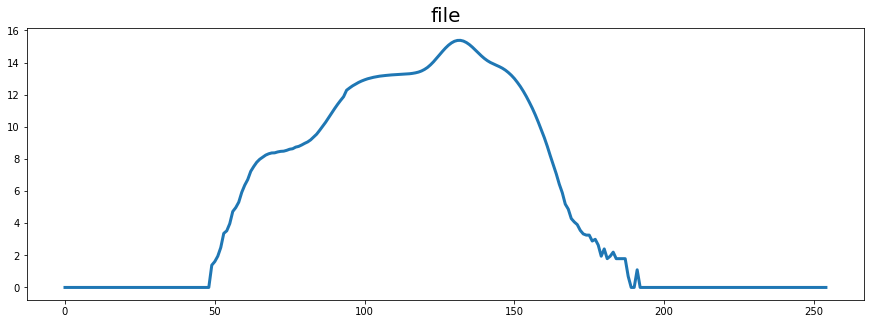

In [8]:
thr = vitaminC.get_individual_threshold(img, True)
print(thr)

In [5]:
rtholded = img.copy()
rtholded[rtholded > 120] = 0
#rtholded[rblur < 10] = 0

size = 3
esize = (size, size, size)
orind = ndimage.grey_opening(rtholded, size=esize, mode='constant')
#orind = ndimage.grey_opening(orind, size=esize, mode='constant')
#orind = ndimage.grey_opening(orind, size=esize, mode='constant')

In [6]:
struc = ndimage.generate_binary_structure(img.ndim, 2)
erind = ndimage.binary_closing(orind, structure=struc, iterations=size)
erind = ndimage.binary_closing(erind, structure=struc, iterations=size)
#erind = ndimage.binary_dilation(erind, structure=struc, iterations=size+2)

In [7]:
trind = vitaminC.get_largest_element(erind)

630 components
[22242478    92598    45839    28570    17969    15310    14982    13834
    10683     8983     8416     7495     6889     6820     5913     5167
     5003     4776     4612     4326]


In [8]:
rind = img*erind

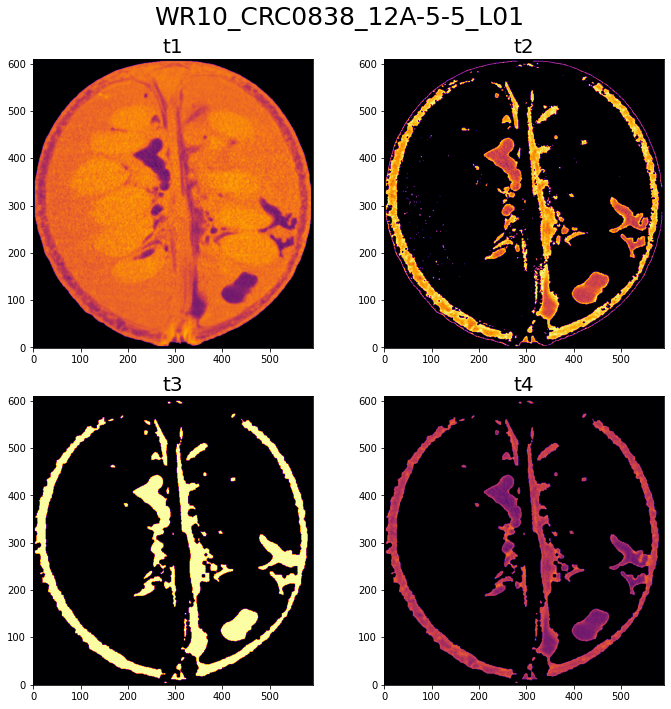

In [9]:
k = 275
ss = np.s_[:, k, :]
vitaminC.plot4x4panel(img, rtholded, erind , rind, ss, bname=bname)

In [142]:
filename = dst + bname + '_rind.tif'
tf.imwrite(filename, rind, photometric='minisblack',compress=3)

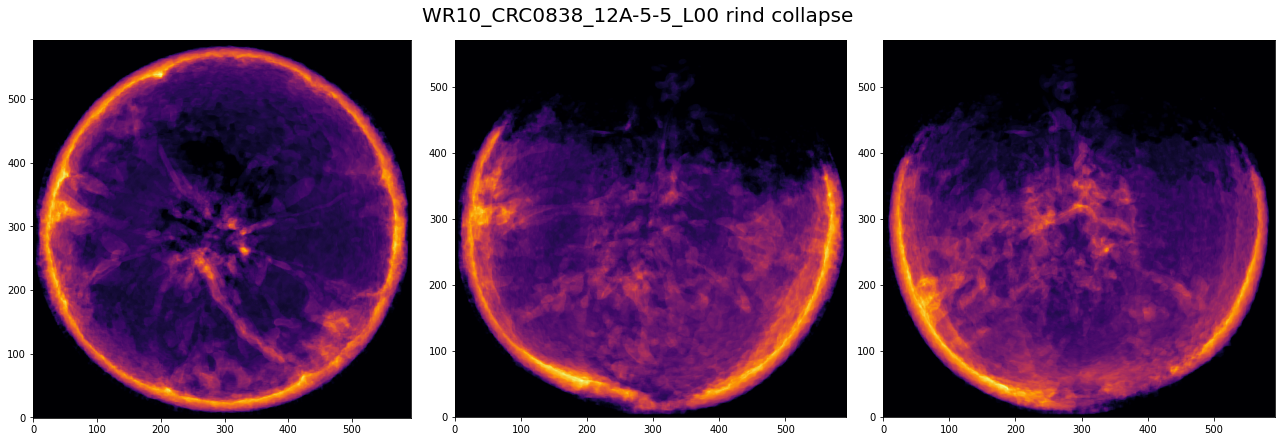

In [141]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(rind)
vitaminC.plot_collapse_dimensions(snaps, bname, 'rind', display=display, writefig=writefig, dst=diag_dst)

# Endocarp

In [23]:
rind = tf.imread(dst + bname + '_rind.tif')
cendo = rind.copy()
cendo[cendo > 0] = 1

eimg = img.copy()
eimg = ndimage.grey_erosion(img, size=(15,15,15), mode='constant')

In [24]:
eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(9,9,9), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(5,5,5), mode='constant')
#eimg = ndimage.grey_erosion(eimg, size=(15,15,15), mode='constant')

In [25]:
dendo = eimg.copy()
dendo[dendo > 0] = 1

endocarp = img*dendo*(1-cendo)

In [26]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

dendo = ndimage.grey_closing(endocarp, size=(15,15,15), mode='constant')
#dendo = ndimage.grey_closing(dendo, size=(9,9,9), mode='constant')
#dendo = ndimage.grey_opening(dendo, size=(9,9,9), mode='constant')

tendo = vitaminC.get_largest_element(dendo)

2 components
[67614191        1]


In [27]:
dendo = ndimage.grey_closing(tendo, size=(9,9,9), mode='constant')
dendo = ndimage.grey_dilation(dendo, size=(9,9,9), mode='constant')

In [28]:
endocarp = img*dendo

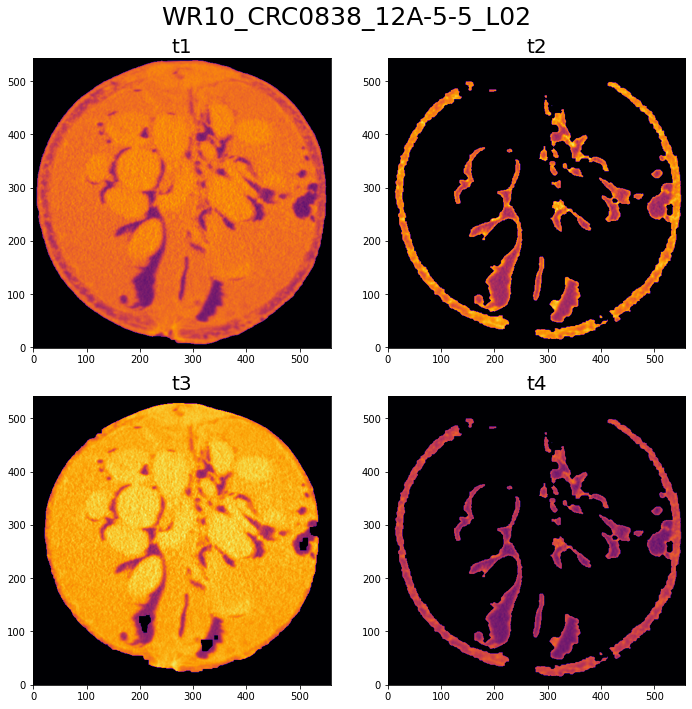

In [29]:
k = 235
ss = np.s_[:, k, :]
vitaminC.plot4x4panel(img, rind,endocarp, rind, ss, bname=bname)

In [31]:
filename = dst + bname + '_endocarp.tif'
tf.imwrite(filename, endocarp, photometric='minisblack',compress=3)

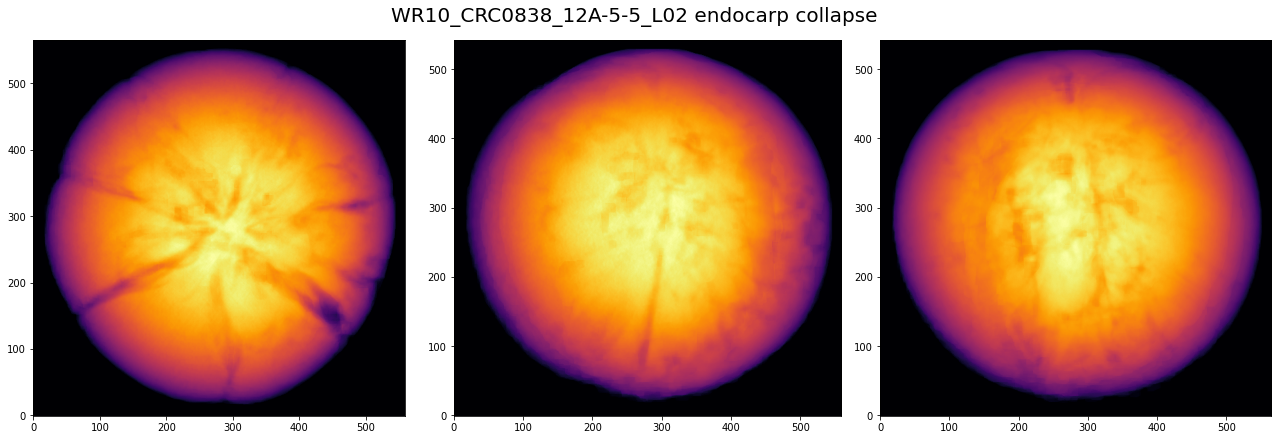

In [30]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(endocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'endocarp', display=display, writefig=writefig, dst=diag_dst)

# Exocarp

In [117]:
dendo = endocarp.copy()
dendo[dendo > 0] = 1

drind = rind.copy()
drind[drind > 0] = 1

In [118]:
comp = drind + dendo - drind*dendo
comp = comp.astype(np.uint8)

In [119]:
rcomp = ndimage.binary_fill_holes(comp)

In [79]:
iters = 5
struc = ndimage.generate_binary_structure(img.ndim, img.ndim-1)

ertholded = ndimage.binary_erosion(rcomp, iterations=iters, structure=struc)

In [84]:
tendo = img*(1-ertholded)
tendo[tendo < 110] = 0
tendo[tendo > 0] = 1
tendo = ndimage.binary_closing(tendo, iterations=5, structure=struc)

In [85]:
exocarp = img*tendo

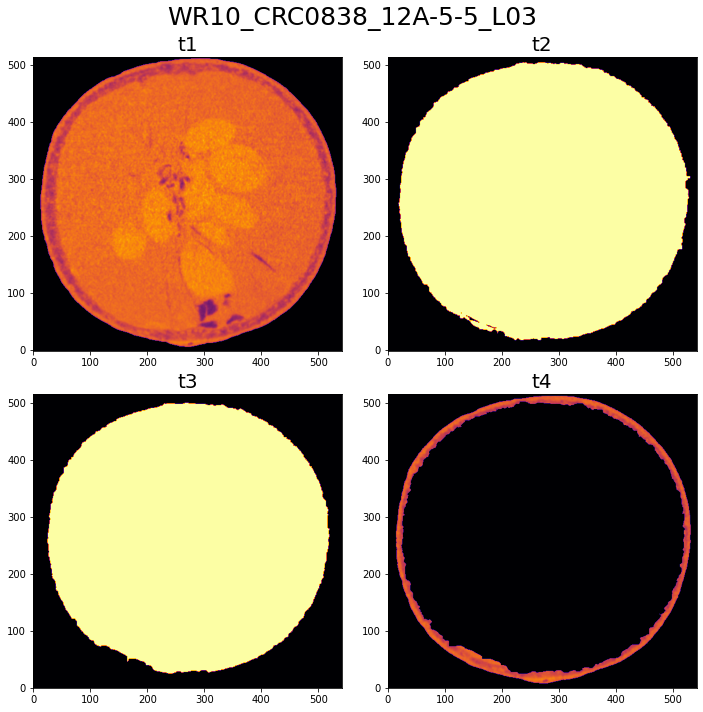

In [86]:
k = 350
ss = np.s_[:, k, :]
vitaminC.plot4x4panel(img, rcomp, ertholded, exocarp, ss, bname=bname)

In [88]:
filename = dst + bname + '_exocarp.tif'
tf.imwrite(filename, exocarp, photometric='minisblack',compress=3)

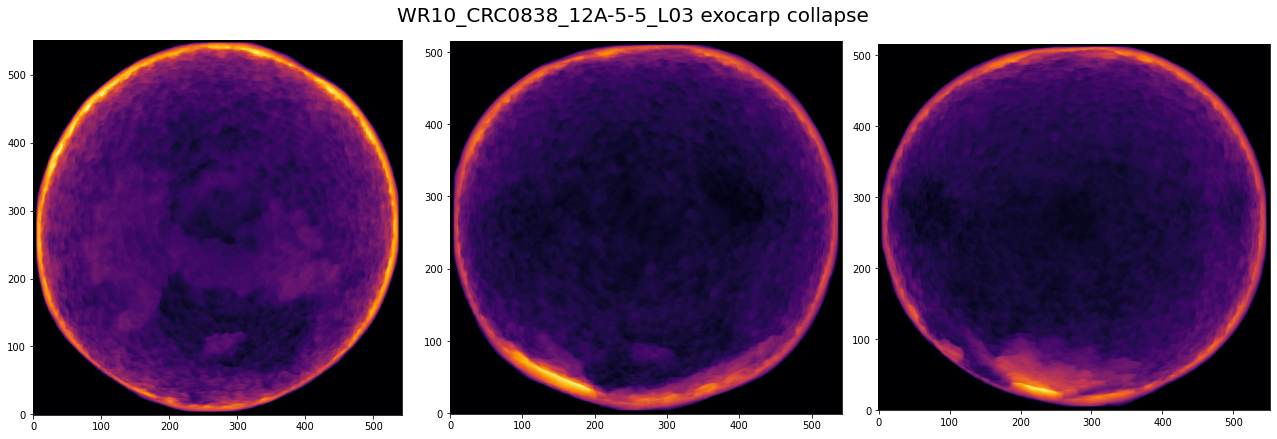

In [87]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(exocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'exocarp', display=display, writefig=writefig, dst=diag_dst)

# Spine

In [152]:
endo = vitaminC.fill_component(dendo)

In [153]:
size = 11
esize = (size, size, size)

eendo = ndimage.grey_erosion(endo, size=esize, mode='constant')

tspine = rind*eendo
tspine = vitaminC.get_largest_element(tspine)

2756 components
[885122 581274 240376  77355  74204  67214  32490  27391  25683  25580
  24522  24301  23574  18896  18874  18864  18186  18041  16054  14986]


In [154]:
size = 5
eesize = (size, size, size)
#orind = ndimage.grey_opening(tspine, size=(8,8,8), mode='constant')
#eesize = (3*size, 1, 1)
orind = ndimage.grey_dilation(tspine, size=eesize, mode='constant')

In [155]:
tspine = vitaminC.get_largest_element(orind)

1 components
[1748443]


In [156]:
spine = rind*orind
mesocarp = rind*(1-orind)

In [157]:
tendo = vitaminC.get_largest_element(mesocarp)

1072 components
[14438168    77355    74204    32490    25580    23574    18896    18874
    18864    18186    18041    16054    14531    14472    14448    14278
    14182    13288    12831    11689]


In [158]:
mesocarp *= tendo

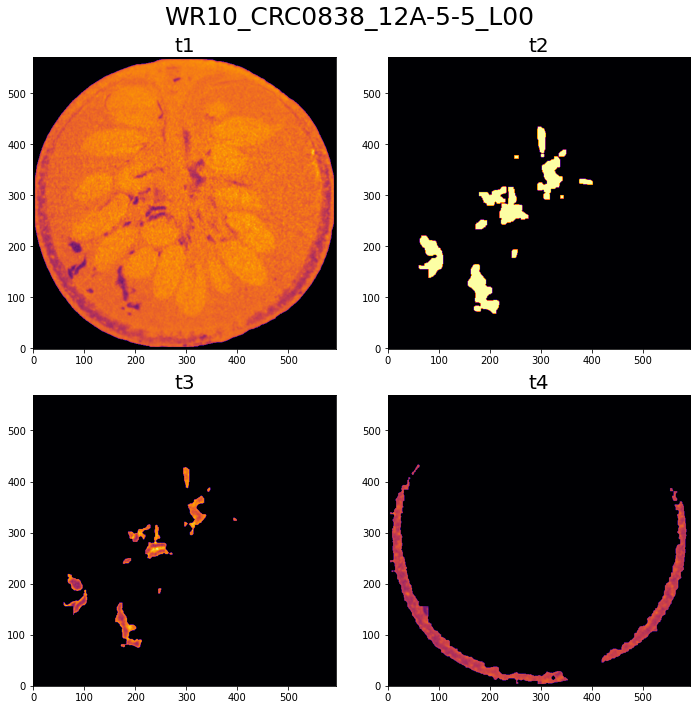

In [159]:
k = 300
ss = np.s_[:, :, k]
vitaminC.plot4x4panel(img, orind, spine, mesocarp, ss, bname=bname)

In [160]:
filename = dst + bname + '_spine.tif'
tf.imwrite(filename, spine, photometric='minisblack',compress=3)

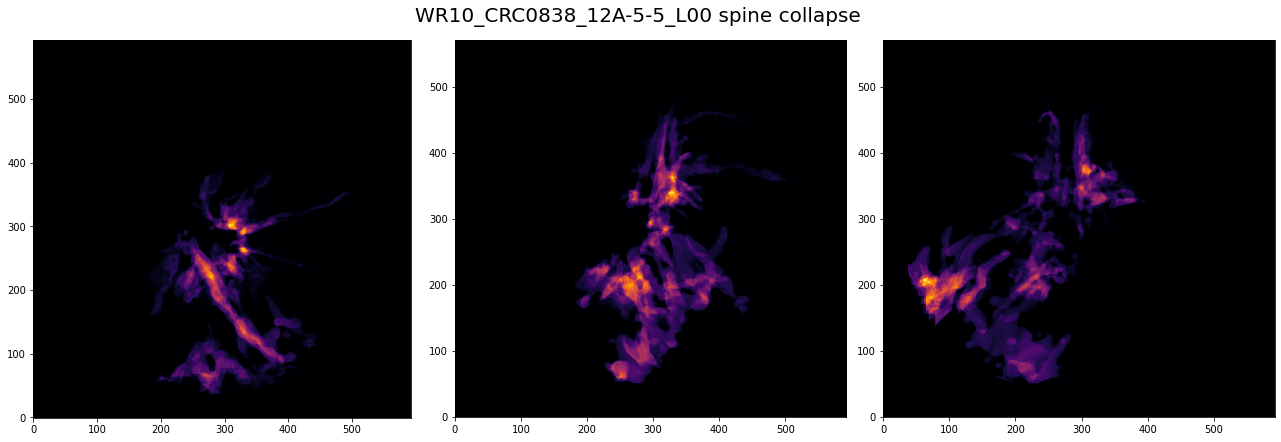

In [161]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(spine)
vitaminC.plot_collapse_dimensions(snaps, bname, 'spine', display=display, writefig=writefig, dst=diag_dst)

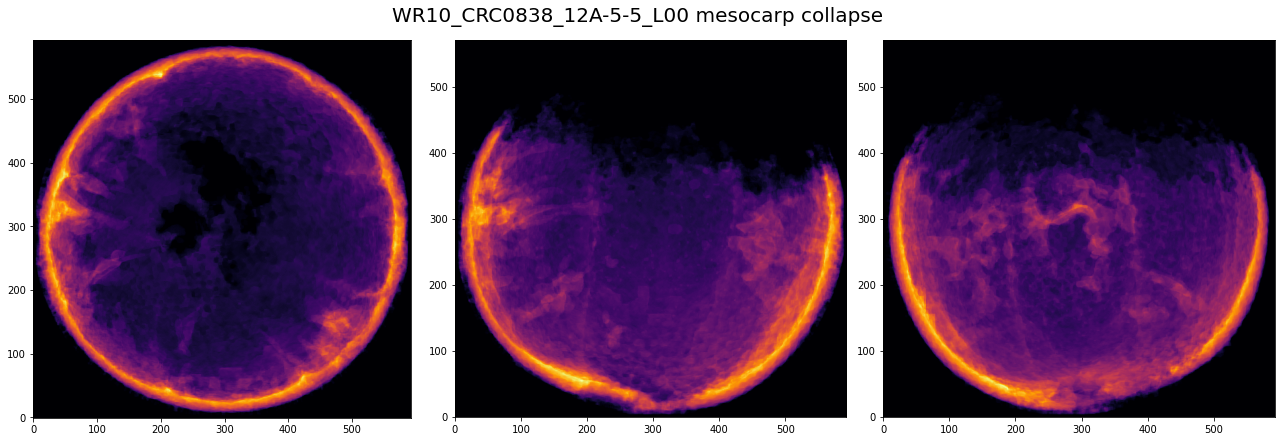

In [162]:
writefig = True
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(mesocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'mesocarp', display=display, writefig=writefig, dst=diag_dst)

# Endocarp

In [83]:
bin_spine = spine.copy()
bin_spine[bin_spine > 0] = 1

In [91]:
size = 5
struc = ndimage.generate_binary_structure(img.ndim, 2)

#rtholded = ndimage.binary_dilation(endo, structure=struc, iterations=size)
rtholded = ndimage.binary_opening(endo, structure=struc, iterations=2*size)
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2*size)

In [92]:
endocarp = rtholded*img*(1-bin_spine)
endocarp[endocarp < 170] = 0

In [93]:
tendo = vitaminC.get_largest_element(endocarp)

8861 components
[67189176     1667     1083     1080     1046     1009      848      716
      604      554      502      483      408      395      393      390
      317      292      279      279]


In [94]:
rtholded = ndimage.binary_closing(tendo, structure=struc, iterations=5)

In [98]:
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2)
rtholded = ndimage.binary_closing(rtholded, structure=struc, iterations=2)

In [99]:
endocarp = rtholded*img

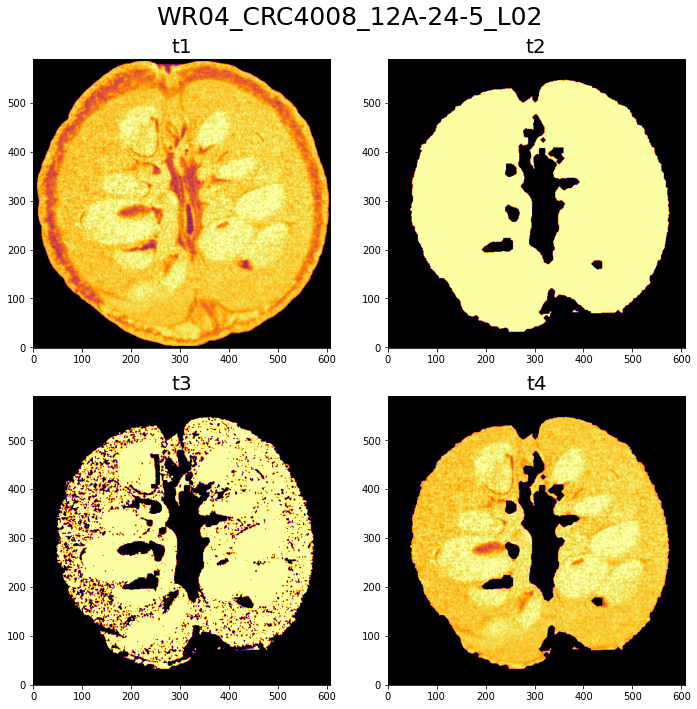

In [100]:
k = 270
ss = np.s_[:,k, :]
vitaminC.plot4x4panel(img, rtholded, tendo, endocarp, ss, bname=bname)

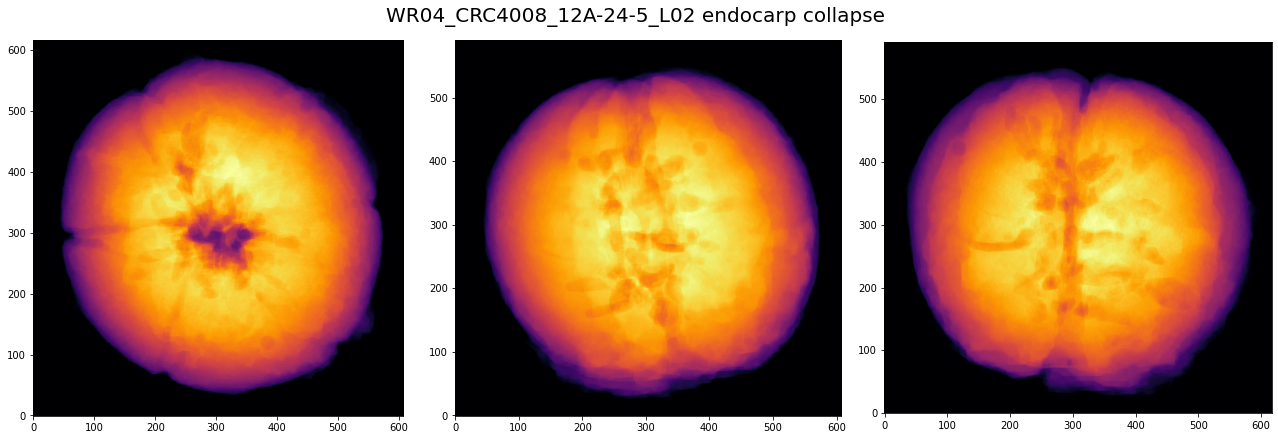

In [101]:
writefig = False
display  = True
diag_dst = init_dst + rname + '/'
snaps = vitaminC.collapse_dimensions(endocarp)
vitaminC.plot_collapse_dimensions(snaps, bname, 'endocarp', display=display, writefig=writefig, dst=diag_dst)